# Deer and Plow

Assumptions:

1. Deer weighs 60 lbs
2. Truck is driving 45 mph
3. Truck does not slow down when it hits the deer
4. The only effects on the deer are gravity, air drag and friction are neglected
5. The deer leaves the plow at 45 mph and an angle of 30° from the vertical
6. The top of the plow is 6 ft off the ground

In [1]:
import pint
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

units = pint.UnitRegistry()
Q_ = units.Quantity
units.setup_matplotlib()

In [2]:
m_deer = Q_(120, "lbs")
V_deer = Q_(45, "mph")
theta_deer = Q_(30, "degree")
h_0 = Q_(6, "ft")

For this kinematics problem, the equations of motion for the deer in 2 dimensions are:

$$\begin{gather*}
\frac{d^2 x}{dt^2} = 0 \\
\frac{dx}{dt} = V_0 \sin{\theta} \\
x(t) = V_0 t \sin{\theta}
\end{gather*}$$

and

$$\begin{gather*}
\frac{d^2 y}{dt^2} = -g \\
\frac{dy}{dt} = -g t + V_0 \cos{\theta} \\
y(t) = -\frac{1}{2}g t^2 + V_0 t \cos{\theta} + h_0
\end{gather*}$$

We need to solve for $t_f$ when $y(t) = 0$, then calculate $x(t_f)$.

In [3]:
a = -1*units.gravity / 2
b = V_deer * np.cos(theta_deer)
c = h_0
t_f = (-b + np.sqrt(b**2 - 4*a*c)) / (2*a)
print(t_f.to("seconds"))

-0.10204215050618629 second


In [4]:
t_f = (-b - np.sqrt(b**2 - 4*a*c)) / (2*a)
print(t_f.to("seconds"))

3.65507195025448 second


In [5]:
x_f = (t_f * V_deer * np.sin(theta_deer)).to("feet")
print(x_f)

120.61737435839781 foot


Now let's relax the assumption that there is no drag. To calculate a drag coefficient, we first need an approximation of the Reynolds number. We'll assume the deer is a smooth sphere 4 ft in diameter. The Reynolds number is

$$\mathrm{Re} = \frac{V D}{\nu}$$

where $D$ is the diameter and $\nu$ is the kinematic viscosity of air. The kinematic viscosity of air is a weak function of temperature. We can assume a value of $12.75\times 10^{-6} \mathrm{m}^2/s$.

In [6]:
nu = Q_(12.75E-6, "m^2/s")
D_deer = Q_(4, "ft")
Re = V_deer * D_deer / nu

print(Re.to("dimensionless"))

1923639.4164705882 dimensionless


This Reynolds Number on the order of $10^6$ gives $C_d\approx 0.1$. It's now easier to write the equations of motion in vector form, where $\vec{r}$ is the position vector and $\vec{v}$ is the velocity vector. Assuming the only forces on the deer when it leaves the plow are air drag and gravity, Newton's second law becomes:

$$
m_{\text{deer}} \frac{d^2 \vec{r}}{dt^2} = \vec{F}_{\text{gravity}} + \vec{F}_{\text{drag}}
$$

Dividing through by $m_{\text{deer}}$ and substituting the definitions of the two forces

$$\begin{gather*}
\frac{d^2 x}{dt^2} = - \frac{\rho C_d V_x^2}{2 m_{\text{deer}}} \\
\frac{d^2 y}{dt^2} = - g - \frac{\rho C_d V_y^2}{2 m_{\text{deer}}} \\
\end{gather*}$$

In [7]:
r_vec_0 = np.array((0, h_0.to("m").magnitude))
v_vec_0 = np.array(((V_deer * np.sin(theta_deer)).to("m/s").magnitude, (V_deer * np.cos(theta_deer)).to("m/s").magnitude))
R_0 = np.hstack((r_vec_0, v_vec_0))
rho = Q_(1.25, "kg/m**3")
C_d = Q_(0.1, "dimensionless")
A_deer = units.pi * D_deer**2 / 4

def equation_of_motion(t, r, turn_on_drag):
    x = Q_(r[0], "m")
    y = Q_(r[1], "m")
    x_dot = Q_(r[2], "m/s")
    y_dot = Q_(r[3], "m/s")

    r_dot = np.zeros_like(r)
    r_dot[:2] = r[2:]

    # r_dot[3] = -(1*units.gravity + 
    r_dot[2] = 0
    if turn_on_drag:
        r_dot[2] += -(A_deer * rho * C_d * x_dot**2 / (2 * m_deer)).to("m/s**2").magnitude
    r_dot[3] = -(1*units.gravity).to("m/s**2").magnitude
    if turn_on_drag:
        r_dot[3] -= (A_deer * rho * C_d * y_dot**2/(2 * m_deer)).to("m/s**2").magnitude
    return r_dot


def hit_the_ground(t, y, _):
    return y[1]

hit_the_ground.terminal = True

First let's solve the problem without drag to make sure we get the same answer.

In [8]:
t_end = 20
turn_on_drag = False
sol = solve_ivp(equation_of_motion, t_span=(0, t_end), y0=R_0, events=(hit_the_ground,), dense_output=True, args=(turn_on_drag,))
print(sol.status)

1


In [9]:
t_eval = np.linspace(sol.sol.t_min, sol.sol.t_max, 1000)
solution = sol.sol(t_eval).T
x = Q_(solution[:, 0], "m")
y = Q_(solution[:, 1], "m")
V_x = Q_(solution[:, 2], "m/s")
V_y = Q_(solution[:, 3], "m/s")
time = Q_(t_eval, "second")
print(time[-1], x[-1].to("ft"), np.max(y).to("ft"), sep="\n")

3.6550719502544786 second
120.61737435839778 foot
56.77068945740749 foot


We do indeed get the same answer. We can also plot the result. The deer goes over 17 meters (56 ft) high!

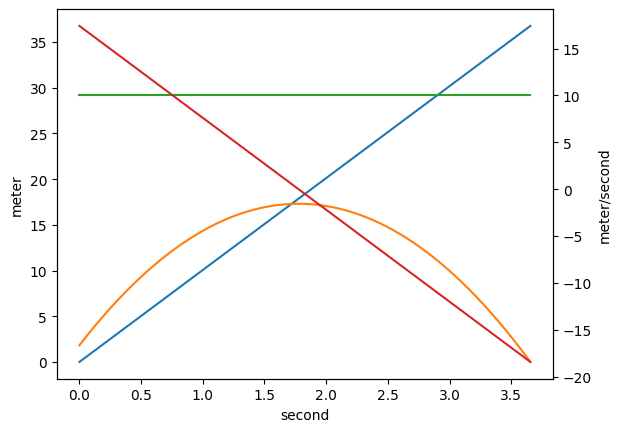

In [10]:
fig, ax = plt.subplots()
ax.plot(time, x, color="C0")
ax.plot(time, y, color="C1")
ax2 = ax.twinx()
ax2.plot(time, V_x, color="C2")
ax2.plot(time, V_y, color="C3")

Now solve the problem with drag.

In [11]:
t_end = 20
turn_on_drag = True
sol = solve_ivp(equation_of_motion, t_span=(0, t_end), y0=R_0, events=(hit_the_ground,), dense_output=True, args=(turn_on_drag,))
print(sol.status)

1


In [12]:
t_eval = np.linspace(sol.sol.t_min, sol.sol.t_max, 1000)
solution = sol.sol(t_eval).T
x = Q_(solution[:, 0], "m")
y = Q_(solution[:, 1], "m")
V_x = Q_(solution[:, 2], "m/s")
V_y = Q_(solution[:, 3], "m/s")
time = Q_(t_eval, "second")
print(time[-1], x[-1].to("ft"), np.max(y).to("ft"), sep="\n")

3.557553781985378 second
112.10403934108355 foot
54.77381846094395 foot


The deer goes about 112 feet, so drag takes off about 8 feet of distance. But that was with a smooth deer, what if we use a rough deer with $C_d = 0.5$?

In [13]:
C_d = Q_(0.5, "dimensionless")
t_end = 20
turn_on_drag = True
sol = solve_ivp(equation_of_motion, t_span=(0, t_end), y0=R_0, events=(hit_the_ground,), dense_output=True, args=(turn_on_drag,))
print(sol.status)

1


In [14]:
t_eval = np.linspace(sol.sol.t_min, sol.sol.t_max, 1000)
solution = sol.sol(t_eval).T
x = Q_(solution[:, 0], "m")
y = Q_(solution[:, 1], "m")
V_x = Q_(solution[:, 2], "m/s")
V_y = Q_(solution[:, 3], "m/s")
time = Q_(t_eval, "second")
print(time[-1], x[-1].to("ft"), np.max(y).to("ft"), sep="\n")

3.257707043182585 second
89.1169824701281 foot
48.46832360032143 foot


That made a big difference, only about 90 feet now!